In [21]:
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from torchvision.datasets import ImageFolder
import sklearn.metrics as metrics
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from torchvision.datasets import CIFAR10, DTD, MNIST, SUN397

In [22]:
test_dypes = ["InD","InD"]
model_ls = ["Resnet18","Resnet50","Resnet101","EffNet_S","EffNet_M","EffNet_L"]
nrow, ncol=2,3
# pred_in_prefix = "../lp-ft/"
pred_in_prefix = "../lp-ft/cal_"
target_prefix = "../lp-ft/target_"
unc_out_prefix = "csv_lp-ft/uncertainty_"
pred_out_prefix = "csv_lp-ft/pred_"

unc1 = "entr_ft"
unc2 = "opt_entr_ft_plus_ce_ft_lp_for_pred_ft"
# unc2 = "entr_ft+ce_ft_lp"
# unc2 = "opt_entr(lp)+entr(ft)_for_sv(lp,ft)"
# unc2 = "entr_ft*ce_ft_lp"
# unc2 = "entr_lp"
# unc2 = "entr_ft+ce_ft_lp"
# evaluatee = "softvote(lp,ft)"
evaluatee = "pred_ft"

In [23]:
# Function to display images in a grid
def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg)
    plt.show()

# Display images in a grid
def show_images(images, n_row, n_col, pred_sub, unc_sub):
    fig, axes = plt.subplots(n_row, n_col, figsize=(16, 16))
    for i in range(n_row):
        for j in range(n_col):
            index = i * n_col + j
            if index < len(images):
                img = images[index]
                npimg = img.numpy()
                axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
                axes[i, j].axis('off')
                target = pred_sub.iloc[index]["target_label"]
                lp_pred = pred_sub.iloc[index]["pred_lp_label"]
                ft_pred = pred_sub.iloc[index]["pred_ft_label"]
                sv_pred = pred_sub.iloc[index]["softvote_label"]
                curr_entr_ft = unc_sub.iloc[index]["entr_ft"]
                curr_entr_lp = unc_sub.iloc[index]["entr_lp"]
                axes[i, j].text(0, -130, f"True: {target}", fontsize=8, color='black')
                axes[i, j].text(0, -50, f"ft: {ft_pred} - entr(ft)={curr_entr_ft:.2f}", fontsize=8, color='green' if ft_pred==target else "red")
                axes[i, j].text(0, -90, f"lp: {lp_pred} - entr(lp)={curr_entr_lp:.2f}", fontsize=8, color='green' if lp_pred==target else "red")
                axes[i, j].text(0, -10, f"SV: {sv_pred}", fontsize=8, color='green' if sv_pred==target else "red")
            else:
                axes[i, j].axis('off')
    plt.subplots_adjust(wspace=0.5, hspace=1)
    plt.show()


In [24]:
random_state = 42 # For reproducibility
test_transform_routine = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for resnets
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert to three channels
    transforms.ToTensor(),  # Transform to tensor for torch
])
# Path to the extracted Caltech256 caltech256
caltech256_path = "data/caltech256"
# Load the caltech256
caltech256 = ImageFolder(root=caltech256_path, transform=test_transform_routine)
train_idx, test_idx = train_test_split(list(range(len(caltech256))), test_size=0.4, random_state=random_state)
val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=random_state)
train = Subset(caltech256, train_idx)
val = Subset(caltech256, val_idx)
test = Subset(caltech256, test_idx)

In [25]:
def main():
    pred = pd.read_csv(f"{pred_out_prefix}{dataset}_{model_to_display}.csv", index_col="Unnamed: 0")
    unc_pred = pd.read_csv(f"{unc_out_prefix}{dataset}_{model_to_display}.csv", index_col="Unnamed: 0")
    display(pred.head(1))
    display(unc_pred.head(1))

    unc1_edge_indices = np.where((unc_pred[f"{unc1}_edge"].values == True) & (unc_pred["correctness(sv)"]==False))[0]
    unc2_edge_indices = np.where((unc_pred[f"{unc2}_edge"].values == True) & (unc_pred["correctness(sv)"]==False))[0]
    unc1_unc2_joint_indices = np.where((unc_pred[f"{unc1}_{unc2}_joint"].values == True) & (unc_pred["correctness(sv)"]==False))[0]
    unc1_unc2_missed_indices = np.where((unc_pred[f"{unc1}_{unc2}_joint"].values == False) & (unc_pred[f"{unc1}_edge"].values == False) & (unc_pred[f"{unc2}_edge"].values == False) & (unc_pred["correctness(sv)"]==False))[0]

    len1=len(unc1_edge_indices)
    len2=len(unc2_edge_indices)
    len3=len(unc1_unc2_joint_indices)
    len4=len(unc1_unc2_missed_indices)
    print(f"unc1 has {len1} unique catches")
    print(f"unc2 has {len2} unique catches")
    print(f"unc1 and unc2 has {len3} joint catches")
    print(f"unc1 and unc2 has {len4} joint misses")
    sample_n = 6
    sampled = np.concatenate((np.random.choice(unc1_edge_indices,sample_n,replace=len1<sample_n) if len1>0 else np.array([], dtype=int),
                            np.random.choice(unc2_edge_indices,sample_n,replace=len2<sample_n) if len2>0 else np.array([], dtype=int),
                            np.random.choice(unc1_unc2_joint_indices,sample_n,replace=len3<sample_n) if len3>0 else np.array([], dtype=int),
                            np.random.choice(unc1_unc2_missed_indices,sample_n,replace=len4<sample_n) if len4>0 else np.array([], dtype=int)
                            ))
    print(sampled)

    pred_sub = pred.loc[sampled]
    unc_sub = unc_pred.iloc[sampled]
    
    pred_sub['pred_ft_label'] = pred_sub['pred_ft'].apply(lambda x: class_labels[x])
    pred_sub['pred_lp_label'] = pred_sub['pred_lp'].apply(lambda x: class_labels[x])
    pred_sub['target_label'] = pred_sub['target'].apply(lambda x: class_labels[x])
    pred_sub['softvote_label'] = pred_sub['softvote(lp,ft)'].apply(lambda x: class_labels[x])
    

    subset = Subset(test, sampled)
    subset_loader = DataLoader(subset, batch_size=32, shuffle=False)
    prev_bs=0
    for i, (images, labels) in enumerate(subset_loader):
        bs = len(images)
        print(f"Batch size: {bs}")
        print(i)
        pred_sub_batch = pred_sub.iloc[i*prev_bs:]  # Select the current batch from pred_sub
        unc_sub_batch = unc_sub.iloc[i*prev_bs:]
        show_images(images, 4,sample_n, pred_sub_batch, unc_sub_batch)
        prev_bs = bs

,pred_lp,pred_ft,"softvote(lp,ft)",top_3_lp,top_3_ft,top_3_sv,target
0,137,233,233,"[137, 7, 256]","[233, 124, 3]","[233, 124, 208]",233


,entr_ft,entr_lp,entr_sv,ce_ft_lp,ce_sv_ft,entr_lp+entr_ft,entr_ft+ce_ft_lp,entr_sv+ce_ft_lp,entr_sv+ce_sv_ft,entr_ft*ce_ft_lp,...,entr_sv+js,entr_ft+js,opt_entr_ft_plus_entr_lp_for_pred_ft,opt_entr_ft_plus_ce_ft_lp_for_pred_ft,"opt_entr(lp)+entr(ft)_for_sv(lp,ft)","opt_entr_lp_plus_ce_ft_lp_for_sv(lp,ft)",entr_ft_edge,opt_entr_ft_plus_ce_ft_lp_for_pred_ft_edge,entr_ft_opt_entr_ft_plus_ce_ft_lp_for_pred_ft_joint,correctness(sv)
0,0.285117,0.904732,1.347813,5.723493,1.927969,1.189849,6.00861,6.00861,2.213086,1.631866,...,2.100701,1.038005,0.331061,1.178798,0.400596,1.865407,False,False,False,True


unc1 has 25 unique catches
unc2 has 38 unique catches
unc1 and unc2 has 469 joint catches
unc1 and unc2 has 606 joint misses
[ 745 5077 2035 5262  249 2811  111 4257 1516 5733 3407 3394 2056 1418
 5044 4116 1017 1769 3975 5449 4530 5697 6088 1304]
Batch size: 24
0


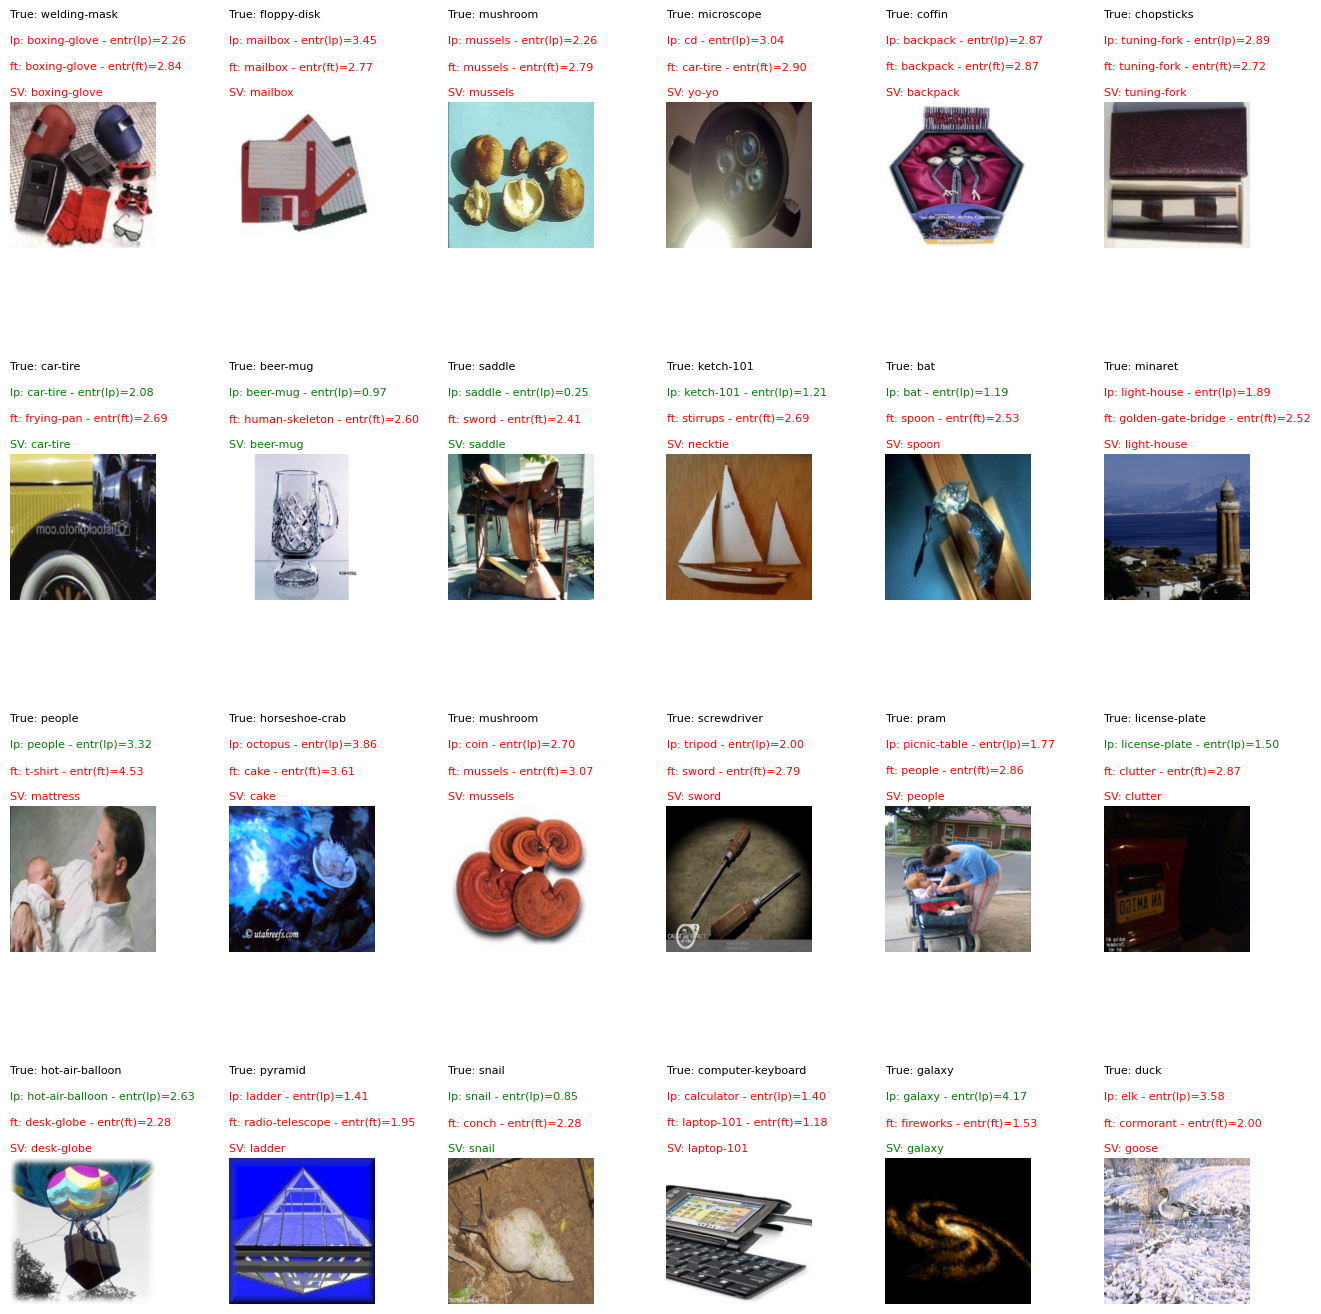

In [26]:
dataset = "caltech256"
model_to_display = "Resnet50"

caltech256 = ImageFolder(root="data/caltech256/256_ObjectCategories")
class_labels = caltech256.classes
class_labels = [label.split('.', 1)[1] for label in class_labels]

main()

Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


,pred_lp,pred_ft,"softvote(lp,ft)",top_3_lp,top_3_ft,top_3_sv,target
0,2,2,2,"[2, 3, 0]","[2, 5, 3]","[2, 3, 5]",2


,entr_ft,entr_lp,entr_sv,ce_ft_lp,ce_sv_ft,entr_lp+entr_ft,entr_ft+ce_ft_lp,entr_sv+ce_ft_lp,entr_sv+ce_sv_ft,entr_ft*ce_ft_lp,...,opt_entr_ft_plus_entr_lp_for_pred_ft,opt_entr_ft_plus_ce_ft_lp_for_pred_ft,opt_entr_ft_times_ce_ft_lp_for_pred_ft,"opt_entr(lp)+entr(ft)_for_sv(lp,ft)","opt_entr_lp_plus_ce_ft_lp_for_sv(lp,ft)","opt_entr_ft_times_ce_ft_lp_for_sv(lp,ft)",entr_ft_edge,opt_entr_ft_plus_ce_ft_lp_for_pred_ft_edge,entr_ft_opt_entr_ft_plus_ce_ft_lp_for_pred_ft_joint,correctness(sv)
0,0.006478,0.609507,0.066418,0.135687,0.081963,0.615985,0.142165,0.142165,0.088441,0.000879,...,0.023397,0.008291,0.009004,0.019772,0.015541,0.01804,False,False,False,True


unc1 has 1 unique catches
unc2 has 0 unique catches
unc1 and unc2 has 155 joint catches
unc1 and unc2 has 28 joint misses
[4290 4290 4290 4290 4290 4290 4686 3097  548 4807 2158 2000 2060 2122
 1865 3566 3309 1763]
Batch size: 18
0


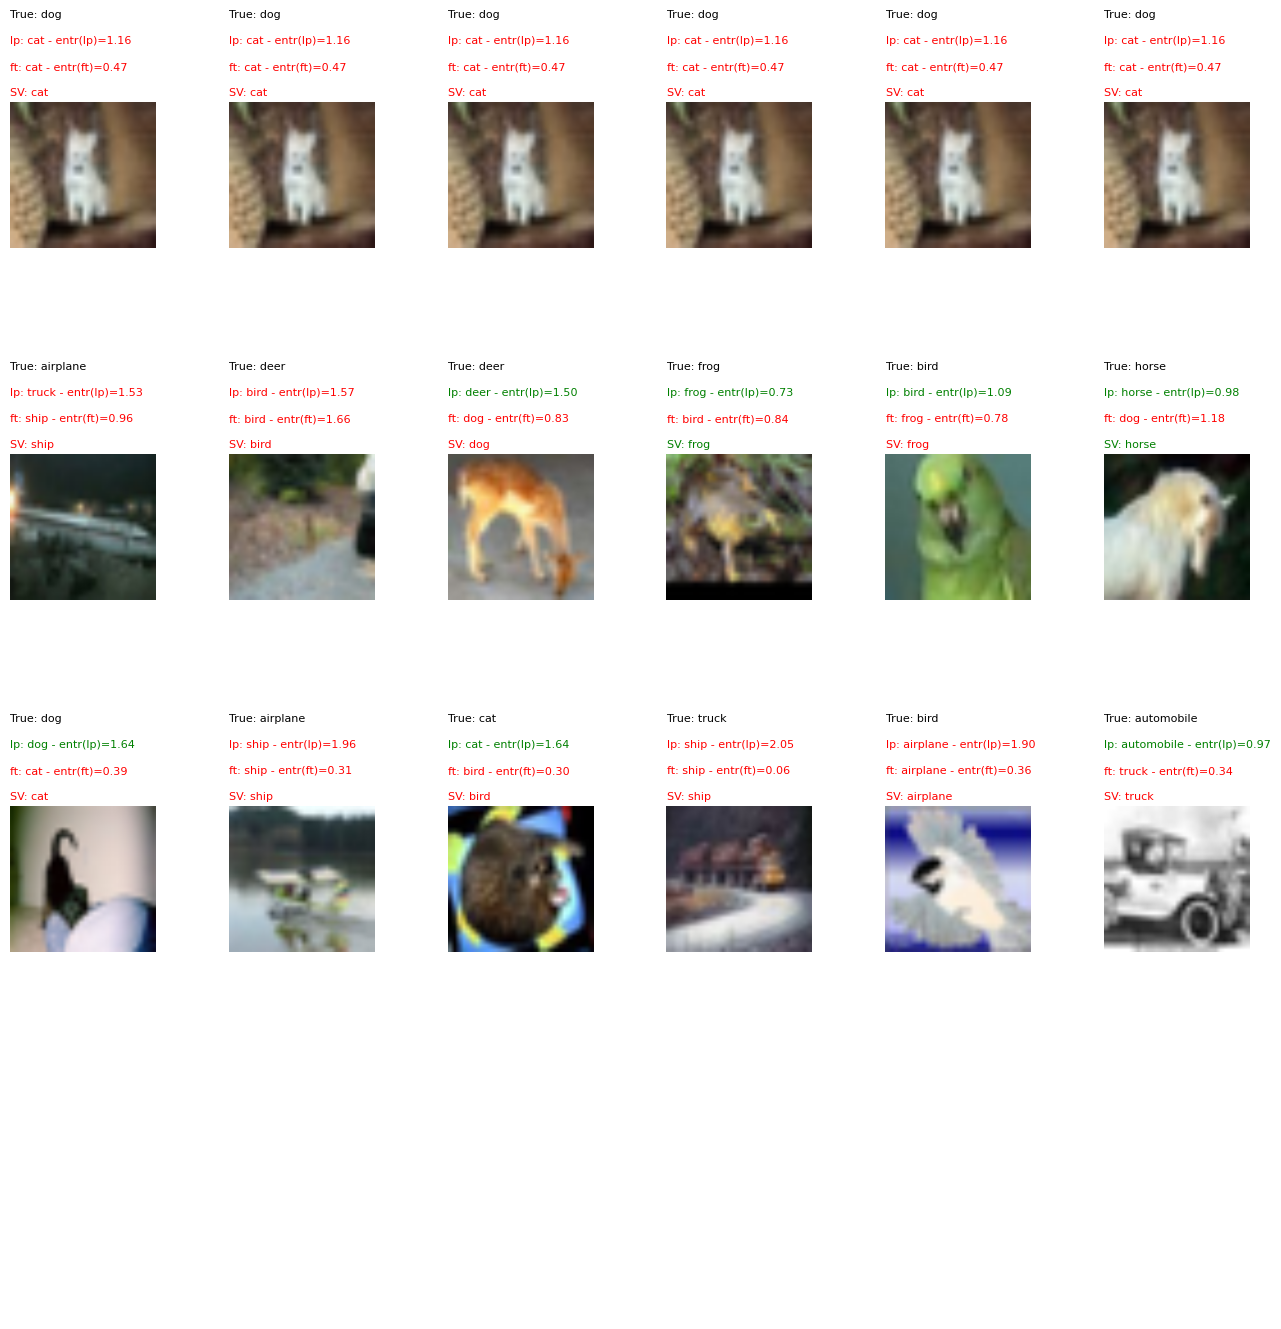

In [27]:
cifar10 = CIFAR10(root='./data', train=False, download=True, transform=test_transform_routine)
# Splitting the dataset into train val test since these datasets don't have default val set
val_idx, test_idx = train_test_split(list(range(len(cifar10))), test_size=0.5, random_state=random_state)
val = Subset(cifar10, val_idx)
test = Subset(cifar10, test_idx)
dataset = "cifar10"
# Get the class labels
class_labels = cifar10.classes
print(class_labels)
main()

['banded', 'blotchy', 'braided', 'bubbly', 'bumpy', 'chequered', 'cobwebbed', 'cracked', 'crosshatched', 'crystalline', 'dotted', 'fibrous', 'flecked', 'freckled', 'frilly', 'gauzy', 'grid', 'grooved', 'honeycombed', 'interlaced', 'knitted', 'lacelike', 'lined', 'marbled', 'matted', 'meshed', 'paisley', 'perforated', 'pitted', 'pleated', 'polka-dotted', 'porous', 'potholed', 'scaly', 'smeared', 'spiralled', 'sprinkled', 'stained', 'stratified', 'striped', 'studded', 'swirly', 'veined', 'waffled', 'woven', 'wrinkled', 'zigzagged']


,pred_lp,pred_ft,"softvote(lp,ft)",top_3_lp,top_3_ft,top_3_sv,target
0,17,17,17,"[17, 44, 29]","[17, 44, 8]","[17, 44, 8]",0


,entr_ft,entr_lp,entr_sv,ce_ft_lp,ce_sv_ft,entr_lp+entr_ft,entr_ft+ce_ft_lp,entr_sv+ce_ft_lp,entr_sv+ce_sv_ft,entr_ft*ce_ft_lp,...,opt_entr_ft_plus_entr_lp_for_pred_ft,opt_entr_ft_plus_ce_ft_lp_for_pred_ft,opt_entr_ft_times_ce_ft_lp_for_pred_ft,"opt_entr(lp)+entr(ft)_for_sv(lp,ft)","opt_entr_lp_plus_ce_ft_lp_for_sv(lp,ft)","opt_entr_ft_times_ce_ft_lp_for_sv(lp,ft)",entr_ft_edge,opt_entr_ft_plus_ce_ft_lp_for_pred_ft_edge,entr_ft_opt_entr_ft_plus_ce_ft_lp_for_pred_ft_joint,correctness(sv)
0,1.98453,3.651111,3.017935,2.823894,3.236656,5.635641,4.808423,4.808423,5.221186,5.604101,...,2.017928,2.677552,2.679974,2.021268,2.793616,2.733547,False,False,False,False


unc1 has 48 unique catches
unc2 has 50 unique catches
unc1 and unc2 has 147 joint catches
unc1 and unc2 has 1330 joint misses
[ 576 1545  880  828 1680  366 1865 1217 1618  845  945   86  537 1627
 1528    4 1531  264 1289 1098  259  839  742 1020]
Batch size: 24
0


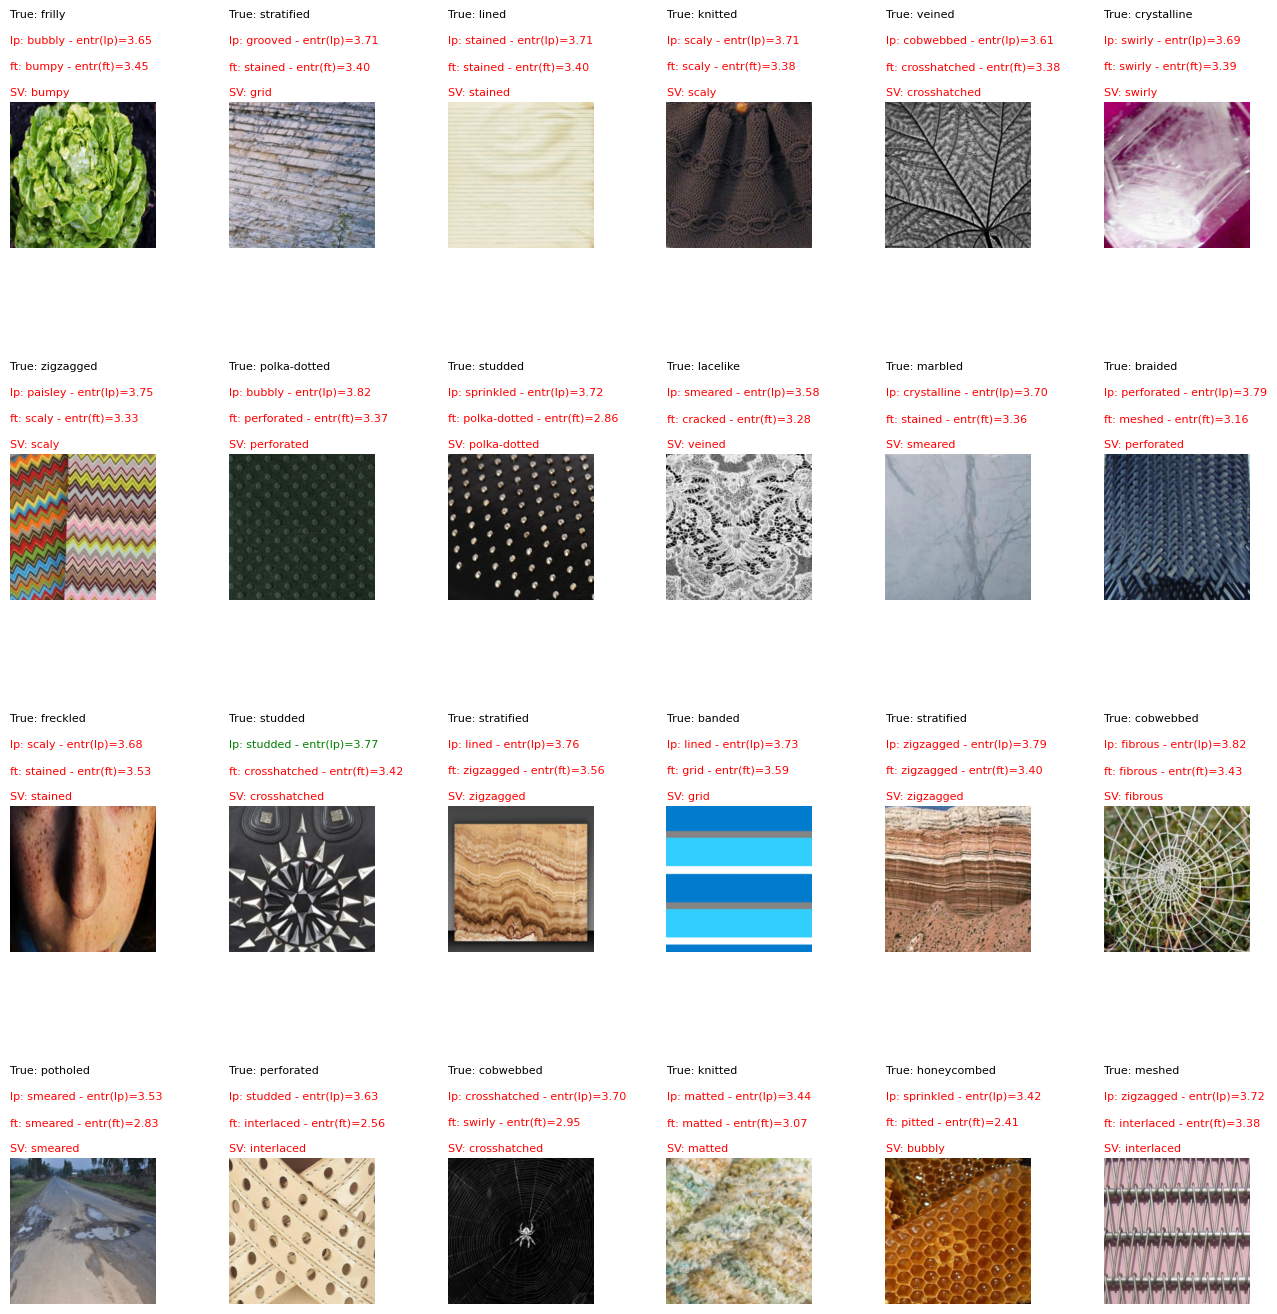

In [28]:
test = DTD(root = "data/", split="test",transform=test_transform_routine, download=True)
dataset = "DTD"
class_labels = test.classes
print(class_labels)
main()

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


,pred_lp,pred_ft,"softvote(lp,ft)",top_3_lp,top_3_ft,top_3_sv,target
0,6,6,6,"[6, 9, 2]","[6, 2, 5]","[6, 2, 5]",6


,entr_ft,entr_lp,entr_sv,ce_ft_lp,ce_sv_ft,entr_lp+entr_ft,entr_ft+ce_ft_lp,entr_sv+ce_ft_lp,entr_sv+ce_sv_ft,entr_ft*ce_ft_lp,...,opt_entr_ft_plus_entr_lp_for_pred_ft,opt_entr_ft_plus_ce_ft_lp_for_pred_ft,opt_entr_ft_times_ce_ft_lp_for_pred_ft,"opt_entr(lp)+entr(ft)_for_sv(lp,ft)","opt_entr_lp_plus_ce_ft_lp_for_sv(lp,ft)","opt_entr_ft_times_ce_ft_lp_for_sv(lp,ft)",entr_ft_edge,opt_entr_ft_plus_ce_ft_lp_for_pred_ft_edge,entr_ft_opt_entr_ft_plus_ce_ft_lp_for_pred_ft_joint,correctness(sv)
0,0.003498,1.684958,0.098664,0.707562,0.141332,1.688457,0.71106,0.71106,0.14483,0.002475,...,0.057413,0.064169,0.0141,0.057413,0.072635,0.035964,False,False,False,True


unc1 has 1 unique catches
unc2 has 0 unique catches
unc1 and unc2 has 64 joint catches
unc1 and unc2 has 1 joint misses
[4800 4800 4800 4800 4800 4800 4776 4381 1832  120 2068 3886 4497 4497
 4497 4497 4497 4497]
Batch size: 18
0


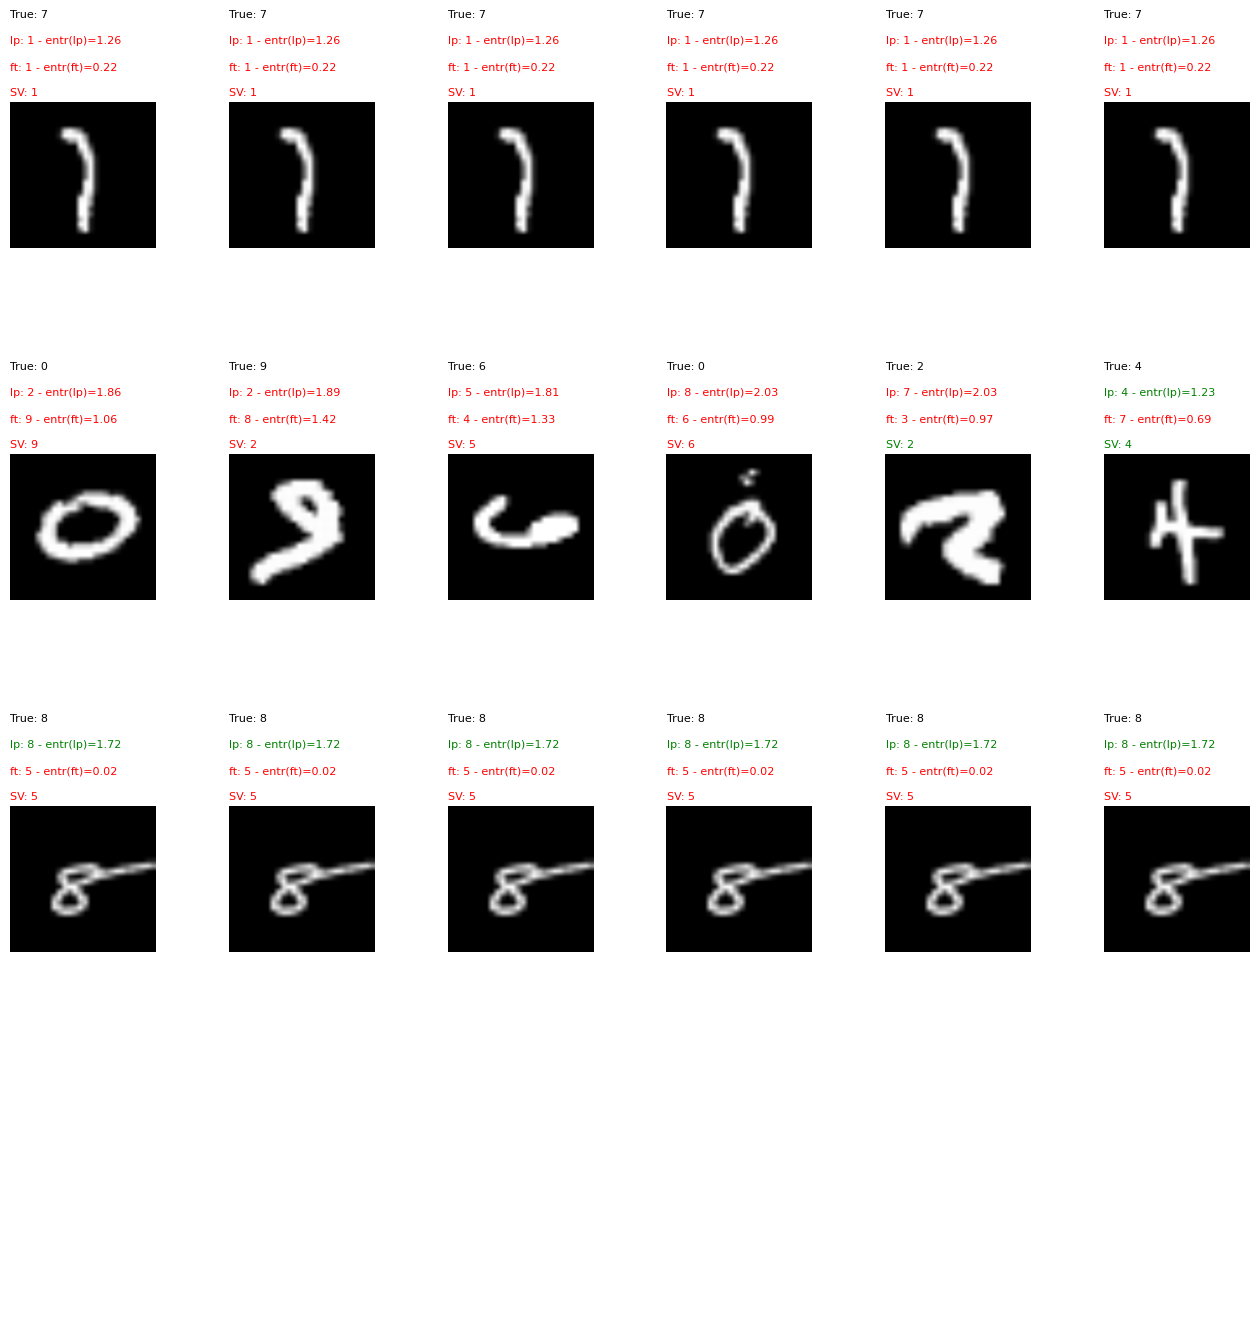

In [29]:
mnist = MNIST(root="data/",train=False, transform=test_transform_routine,download=True)
val_idx, test_idx = train_test_split(list(range(len(mnist))), test_size=0.5, random_state=random_state)
test = Subset(mnist, test_idx)
dataset = "MNIST"
# Get the class labels
class_labels = [str(i) for i in range(10)]
print(class_labels)
main()

In [30]:
# sun397 = SUN397(root="data/", transform=test_transform_routine, download=True)
# train_idx, test_idx = train_test_split(list(range(len(sun397))), test_size=0.4, random_state=random_state)
# val_idx, test_idx = train_test_split(test_idx, test_size=0.5, random_state=random_state)
# test = Subset(sun397, test_idx)
# dataset = "Sun397"
# class_labels = test.classes
# print(class_labels)
# main()